In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Dimensionality Reduction on TfIdf vectors with chi2 feature selection.
The chi2 feature selection measures the lack of independence between a term(one of the top 1,00,000 words of the natural corpora used for TfIdf vectorizer) and the class(positive or negative).
It is based on a contingency table, a fancy term for a frequency distribution table.

                       Positive       Negative
                       
Term occurs:                A              B

Term does'nt occur:         C              D

Chi-squared statistic = Nx(AD-BC)^2 / (A+C)x(B+D)x(A+B)x(C+D)
where, N is the total number of samples.

In [2]:
csv = 'df.csv'
df = pd.read_csv(csv, index_col=0)
df.tail()

/home/harshit/.local/lib/python3.5/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
1596036,just woke up having no school is the best feel...,4
1596037,thewdb com very cool to hear old walt interviews,4
1596038,are you ready for your mojo makeover ask me fo...,4
1596039,happy th birthday to my boo of alll time tupac...,4
1596040,happy charitytuesday,4


In [3]:
df.loc[df.target == 4, 'target'] = 1

In [4]:
df.tail()

,text,target
1596036,just woke up having no school is the best feel...,1
1596037,thewdb com very cool to hear old walt interviews,1
1596038,are you ready for your mojo makeover ask me fo...,1
1596039,happy th birthday to my boo of alll time tupac...,1
1596040,happy charitytuesday,1


In [5]:
from sklearn.cross_validation import train_test_split

x = df.text
y = df.target
SEED = 2000

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train), (len(x_train[y_train == 0]) / (len(x_train)*1.))*100, (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation), (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test), (len(x_test[y_test == 0]) / (len(x_test)*1.))*100, (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.45% negative, 50.55% positive
Test set has total 15961 entries with 49.68% negative, 50.32% positive


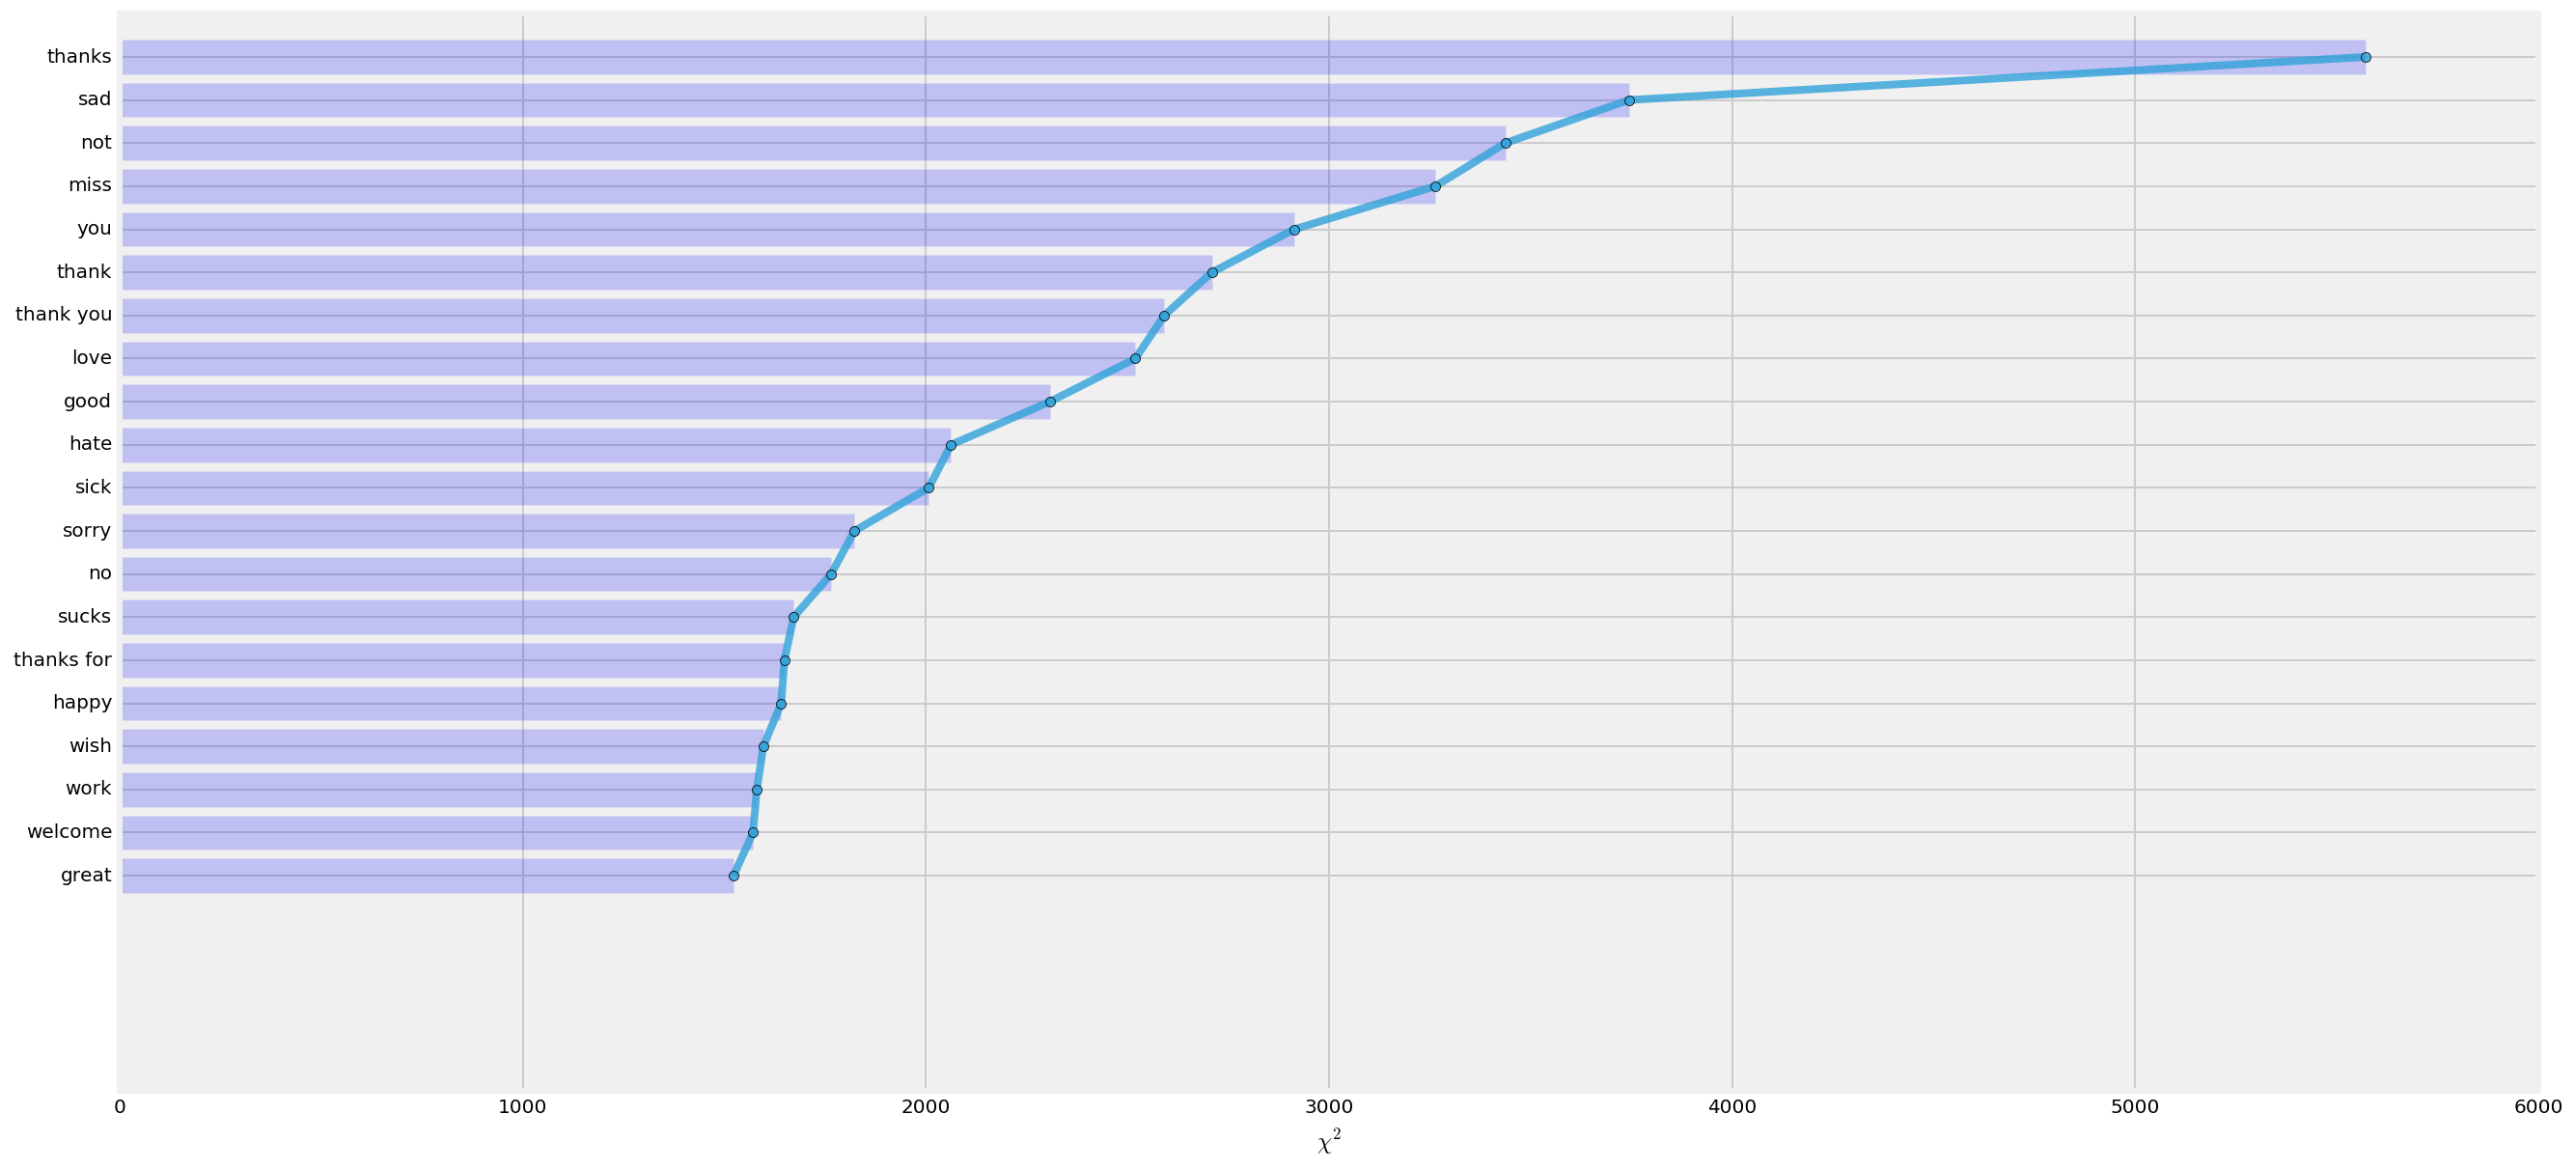

In [9]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)
chi2score = chi2(x_train_tfidf, y_train)[0]

plt.figure(figsize=(20, 10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x, topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [ ]:
from sklearn.feature_selection import SelectKBest

ch2_result = []
for n in np.arange(10000, 100000, 10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy, label='trigram tfidf vectorizer', color='royalblue')
plt.plot(np.arange(10000, 100000, 10000), ch2_result, label='tfidf dimesions reduced from 100,000 features', linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)
d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, d2v_pca.n_components_+1)
ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [10]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [ ]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch, y_batch
        if (counter > number_of_batches):
            counter=0
            
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=100000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

In [ ]:
from sklearn.preprocessing import Normalizer

norm = Normalizer().fit(x_train_tfidf)
x_train_tfidf_norm = norm.transform(x_train_tfidf)
x_validation_tfidf_norm = norm.transform(x_validation_tfidf)

In [ ]:
from gensim.models import Doc2Vec

def get_concat_vectors(model1, model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs
    
model_ug_dbow = Doc2Vec.load('d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow, model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow, model_tg_dmm, x_validation, 200)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(train_vecs_ugdbow_tgdmm, y_train)

print clf.score(train_vecs_ugdbow_tgdmm, y_train)
print clf.score(validation_vecs_ugdbow_tgdmm, y_validation)

In [ ]:
seed = 7

# Model example 1: 1 hidden layer with 64 hidden nodes
np.random.seed(seed)
model_d2v_01 = Sequential()
model_d2v_01.add(Dense(64, activation='relu', input_dim=200))
model_d2v_01.add(Dense(1, activation='sigmoid'))
model_d2v_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_01.fit(train_vecs_ugdbow_tgdmm, y_train,
                 validation_data=(validation_vecs_ugdbow_tgdmm, y_validation),
                 epochs=10, batch_size=32, verbose=2)

# Model example 2: 2 hidden layers with 64 hidden nodes each
np.random.seed(seed)
model_d2v_02 = Sequential()
model_d2v_02.add(Dense(64, activation='relu', input_dim=200))
model_d2v_02.add(Dense(64, activation='relu'))
model_d2v_02.add(Dense(1, activation='sigmoid'))
model_d2v_02.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_02.fit(train_vecs_ugdbow_tgdmm, y_train,
                 validation_data=(validation_vecs_ugdbow_tgdmm, y_validation),
                 epochs=10, batch_size=32, verbose=2)

In [ ]:
# Early stopping

from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="d2v_09_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]

np.random.seed(seed)
model_d2v_09_es = Sequential()
model_d2v_09_es.add(Dense(256, activation='relu', input_dim=200))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dense(1, activation='sigmoid'))
model_d2v_09_es.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_09_es.fit(train_vecs_ugdbow_tgdmm, y_train,
                    validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), 
                    epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)

In [ ]:
from keras.models import load_model
loaded_model = load_model('d2v_09_best_weights.07-0.7993.hdf5')
loaded_model.evaluate(x=validation_vecs_ugdbow_tgdmm, y=y_validation)

In [ ]:
model_ug_dmm = Doc2Vec.load('d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

def get_w2v_ugdbowdmm(tweet, size, is_sum):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_dbow[word], model_ug_dmm[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if is_sum is False and count != 0:
        vec /= count
    return vec
  
train_vecs_w2v_dbowdmm = np.concatenate([get_w2v_ugdbowdmm(z, 200, False) for z in x_train])
validation_vecs_w2v_dbowdmm = np.concatenate([get_w2v_ugdbowdmm(z, 200, False) for z in x_validation])

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm, y_train)
clf.score(validation_vecs_w2v_dbowdmm, y_validation)

In [ ]:
# Standardise each feature with 0 mean and unit variance
# Scaling greatly reduces the tarining time.
from sklearn.preprocessing import scale

train_vecs_w2v_dbowdmm_s = scale(train_vecs_w2v_dbowdmm)
validation_vecs_w2v_dbowdmm_s = scale(validation_vecs_w2v_dbowdmm)

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm_s, y_train)
clf.score(validation_vecs_w2v_dbowdmm_s, y_validation)

In [ ]:
train_vecs_w2v_dbowdmm_sum = np.concatenate([get_w2v_ugdbowdmm(z, 200, True) for z in x_train])
validation_vecs_w2v_dbowdmm_sum = np.concatenate([get_w2v_ugdbowdmm(z, 200, True) for z in x_validation])

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm_sum, y_train)
clf.score(validation_vecs_w2v_dbowdmm_sum, y_validation)

In [ ]:
train_vecs_w2v_dbowdmm_sum_s = scale(train_vecs_w2v_dbowdmm_sum)
validation_vecs_w2v_dbowdmm_sum_s = scale(validation_vecs_w2v_dbowdmm_sum)

clf = LogisticRegression()
clf.fit(train_vecs_w2v_dbowdmm_sum_s, y_train)
clf.score(validation_vecs_w2v_dbowdmm_sum_s, y_validation)

In [ ]:
# Word vectors extracted from Doc2Vec models with TFIDF weighting (Average/Sum)
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(min_df=2)
tvec.fit_transform(x_train)
tfidf = dict(zip(tvec.get_feature_names(), tvec.idf_))

def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

w2v_tfidf = {}
for w in model_ug_dbow.wv.vocab.keys():
    if w in tvec.get_feature_names():
        w2v_tfidf[w] = np.append(model_ug_dbow[w], model_ug_dmm[w]) * tfidf[w]
        
train_vecs_w2v_tfidf_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'mean') for z in x_train]))
validation_vecs_w2v_tfidf_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_tfidf_mean, y_train)
print(clf.score(validation_vecs_w2v_tfidf_mean, y_validation))

train_vecs_w2v_tfidf_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'sum') for z in x_train]))
validation_vecs_w2v_tfidf_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_tfidf, 'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_tfidf_sum, y_train)
print(clf.score(validation_vecs_w2v_tfidf_sum, y_validation))

In [ ]:
# Word vectors extracted from Doc2Vec models with custom weighting (Average/Sum)
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm

cvec = CountVectorizer(max_features=100000)
cvec.fit(x_train)

neg_train = x_train[y_train == 0]
pos_train = x_train[y_train == 1]
neg_doc_matrix = cvec.transform(neg_train)
pos_doc_matrix = cvec.transform(pos_train)
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2 = pd.DataFrame([neg, pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
pos_hmean = term_freq_df2.pos_normcdf_hmean

w2v_pos_hmean = {}
for w in model_ug_dbow.wv.vocab.keys():
    if w in pos_hmean.keys():
        w2v_pos_hmean[w] = np.append(model_ug_dbow[w], model_ug_dmm[w]) * pos_hmean[w]
        
train_vecs_w2v_poshmean_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'mean') for z in x_train]))
validation_vecs_w2v_poshmean_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_mean, y_train)
print(clf.score(validation_vecs_w2v_poshmean_mean, y_validation))

train_vecs_w2v_poshmean_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'sum') for z in x_train]))
validation_vecs_w2v_poshmean_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_sum, y_train)
print(clf.score(validation_vecs_w2v_poshmean_sum, y_validation))

GloVe (Global Vectors for word representation)

Xij be the number of times word i appears in the context of j, where Xij = Xji. where context and target are defined as whether they appear in close proximity.

The model is trained to minimise the summation of the squared difference between (Wi)^T(Wj) + Bi + Bj and Xij.

In [ ]:
# Word vectors extracted from pre-trained GloVe (Average/Sum)
import gensim.downloader as api

glove_twitter = api.load("glove-twitter-200")

train_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter, 'mean') for z in x_train]))
validation_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_glove_mean, y_train)
print(clf.score(validation_vecs_glove_mean, y_validation))

train_vecs_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'sum') for z in x_train]))
validation_vecs_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_glove_sum, y_train)
print(clf.score(validation_vecs_glove_sum, y_validation))

In [ ]:
# Word vectors extracted from pre-trained Google News Word2Vec (Average/Sum)
import gensim.downloader as api

googlenews = api.load("word2vec-google-news-300")

train_vecs_googlenews_mean = scale(np.concatenate([get_w2v_general(z, 300, googlenews, 'mean') for z in x_train]))
validation_vecs_googlenews_mean = scale(np.concatenate([get_w2v_general(z, 300, googlenews, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_googlenews_mean, y_train)
print clf.score(validation_vecs_googlenews_mean, y_validation)

train_vecs_googlenews_sum = scale(np.concatenate([get_w2v_general(z, 300, googlenews,'sum') for z in x_train]))
validation_vecs_googlenews_sum = scale(np.concatenate([get_w2v_general(z, 300, googlenews,'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_googlenews_sum, y_train)
print clf.score(validation_vecs_googlenews_sum, y_validation)

In [ ]:
# Separately trained Word2Vec (Average/Sum)
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

def labelize_tweets_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = pd.concat([x_train, x_validation, x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2,
                         workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                        total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2,
                       workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                      total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

def get_w2v_mean(tweet, size, is_sum=False):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word], model_ug_sg[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if is_sum is False and count != 0:
        vec /= count
    return vec
  
train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_train]))
validation_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_mean, y_train)
print(clf.score(validation_vecs_cbowsg_mean, y_validation))

train_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_mean(z, 200, True) for z in x_train]))
validation_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_mean(z, 200, True) for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_sum, y_train)
print(clf.score(validation_vecs_cbowsg_sum, y_validation))

In [ ]:
w2v_pos_hmean_01 = {}
for w in model_ug_cbow.wv.vocab.keys():
    if w in pos_hmean.keys():
        w2v_pos_hmean_01[w] = np.append(model_ug_cbow[w], model_ug_sg[w]) * pos_hmean[w]
        
train_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in x_train]))
validation_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_mean_01, y_train)
print(clf.score(validation_vecs_w2v_poshmean_mean_01, y_validation))

train_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in x_train]))
validation_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_sum_01, y_train)
print(clf.score(validation_vecs_w2v_poshmean_sum_01, y_validation))

In [ ]:
train_w2v_final = train_vecs_w2v_poshmean_mean_01
validation_w2v_final = validation_vecs_w2v_poshmean_mean_01

filepath="w2v_01_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
np.random.seed(seed)
model_w2v_01 = Sequential()
model_w2v_01.add(Dense(256, activation='relu', input_dim=200))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(1, activation='sigmoid'))
model_w2v_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_w2v_01.fit(train_w2v_final, y_train, validation_data=(validation_w2v_final, y_validation), 
                 epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)